In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta, uniform
from math import comb
import pymc3 as pm
import arviz as az

# Problem 1

In [86]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    theta = np.linspace(0,1,n)
    #set up our list of flips
    x = np.random.binomial(1,p,n)
    #prior
    prior = 1
    binomial = lambda t: t**(np.sum(x)) * (1-t)**(n-np.sum(x))
    
    f_x_theta = binomial(theta)
    
    denom = np.sum(f_x_theta) * (theta[1] - theta[0])
        
    post = f_x_theta/denom
    
    plt.plot(theta, post, label='Posterior Distribution')
    plt.legend()
    plt.show()
    
    return theta[np.argmax(post)]

In [87]:
bernoulli_sampling(0.2, 100)

0.17171717171717174

# Problem 2

In [104]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    t = np.linspace(0,1,n)
    x = np.random.binomial(1,p,n)
    
    binomial = lambda t: t**(np.sum(x)) * (1-t)**(n-np.sum(x))
    
    f_x_theta = binomial(t)
    
    g_theta = prior.pdf(t)
    
    denom = np.sum(f_x_theta) * np.sum(g_theta) * (t[1] - t[0])
        
    post = (f_x_theta * g_theta)/denom
    
    
#     plt.plot(t, g_theta, label='Prior Distribution')
    plt.plot(t, post, label='Posterior Distribution')
    plt.legend()
    plt.show()
    
    return t[np.argmax(post)]

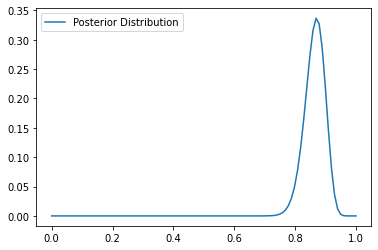

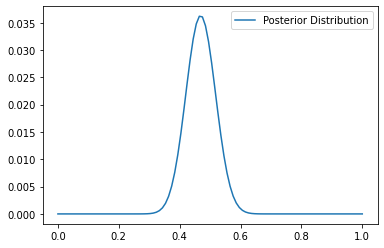

0.8686868686868687
0.4646464646464647


In [106]:
prior = beta(5, 1.5)
p_1 = 0.9
p_2 = 0.4

n = 100

MAP_9 = non_uniform_prior(p_1, n, prior)
MAP_4 = non_uniform_prior(p_2, n, prior)

print(MAP_9)
print(MAP_4)

# Problem 3

In [123]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    weather = ['sun', 'wind', 'rain']
    forecast = ['sun']
    
    for i in range(1,days):
        if forecast[i-1] == 'sun':
            next_day = np.random.choice(weather, p=transition_matrix[0,:])
        elif forecast[i-1] == 'wind':
            next_day = np.random.choice(weather, p=transition_matrix[1,:])
        else:
            next_day = np.random.choice(weather, p=transition_matrix[2,:])
        forecast.append(next_day)
        
    return forecast

In [124]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

forecast = weather_forecast(transition_matrix)

print(forecast)

['sun', 'wind', 'wind', 'wind', 'rain', 'sun', 'sun', 'rain', 'wind', 'wind']


# Problem 4

In [132]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
        p = pm.Beta('p', alpha=1, beta=1)
        y = pm.Bernoulli('y', p=p, observed=data)
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        p = trace['p']
        mean = p.mean()

    return mean

In [133]:
data = bernoulli.rvs(0.2, size=30)

posterior_sampling(data)

/var/folders/lj/bn7k_d612h70yjqxkxbdx9nr0000gp/T/ipykernel_5782/3361367846.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


0.24777584037712846

# Problem 5

In [134]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        mu = pm.Normal('mu', m, s)
        tau = pm.Gamma('tau', alpha, beta)
        y = pm.Normal('y', mu, 1/tau, observed=observed_heights)
        trace = pm.sample(n) #n is the desired number of samples
        az.plot_trace(trace)
        mu = trace['mu']
        mean = mu.mean()
        
        plt.tight_layout(pad=3.0)
    return mean
    

In [136]:
heights = np.random.normal(180,10,100)
height_model(heights)

/var/folders/lj/bn7k_d612h70yjqxkxbdx9nr0000gp/T/ipykernel_5782/1898500031.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


179.3800035455102